In [11249]:
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')

In [11250]:
import seaborn as sns
sns.set_palette('Set2')

import matplotlib.pyplot as plt
%matplotlib inline

In [11251]:
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVC, SVC, LinearSVR, SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from scipy.stats import zscore
from sklearn.metrics import mean_squared_error

In [11252]:
import requests
import json
from datetime import datetime
import time

In [11253]:
import os
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

In [11254]:
from config import yelp_api_key
from config import darksky_api_key

## Set Up

In [11315]:
# Analysis Dates
start_date = '2017-01-01' # Start Date Inclusive
end_date = '2019-06-19' # End Date Exclusive

In [11316]:
search_business = 'Jupiter Disco'
location = 'Brooklyn, NY'

## Pull Weather Data

### Latitude + Longitude from Yelp API

In [9039]:
host = 'https://api.yelp.com'
path = '/v3/businesses/search'

search_limit = 10

# Yelp Authorization Header with API Key
headers = {
        'Authorization': 'Bearer {}'.format(yelp_api_key) 
    }

# Build Requests Syntax with Yelp Host and Path and URL Paramaters
# Return JSON response
def request(host, path, url_params=None):
    
    url_params = url_params or {}
    url = '{}{}'.format(host, path)

    response = requests.get(url, headers=headers, params=url_params)
    
    return response.json()

# Build URL Params for the Request and provide the host and path
def search(term, location):
    
    url_params = {
        'term': term.replace(' ', '+'),
        'location': location.replace(' ', '+'),
        'limit': search_limit
    }
    
    return request(host, path, url_params=url_params)

# Return Coordinates if Exact Match Found
def yelp_lat_long(business, location):
    
    # Call search function here with business name and location
    response = search(business, location)
    
    # Set state to 'No Match' in case no Yelp match found
    state = 'No Match'
    possible_matches = []
    
    # Check search returns for match wtith business
    for i in range(len(response['businesses'])):

        # If match found:
        if response['businesses'][i]['name'] == business:

            # Local variables to help navigate JSON return
            response_ = response['businesses'][0]
            name_ = response_['name']

            print(f'Weather Location: {name_}')
            state = 'Match Found'
            #print(response['businesses'][0])
            return response_['coordinates']['latitude'], response_['coordinates']['longitude']

        else:
            
            # If no exact match, append all search returns to list
            possible_matches.append(response['businesses'][i]['name'])
    
    # If no match, show user potential matches
    if state == 'No Match':
        
        print('Exact match not found, did you mean one of the following? \n')
        
        for possible_match in possible_matches:
            print(possible_match)
            
        return None, None

lat, long = yelp_lat_long(search_business, location)
#print(f'Latitude: {lat}\nLongitude: {long}')

Weather Location: Jupiter Disco


### Darksky API Call

In [9040]:
# Create List of Dates of target Weather Data
def find_dates(start_date, end_date):
    
    list_of_days = []
    daterange = pd.date_range(start_date, end_date)
    for single_date in daterange:
        list_of_days.append(single_date.strftime("%Y-%m-%d"))
    
    return list_of_days

In [9041]:
# Concatenate URL to make API Call
def build_url(api_key, lat, long, day):
    
    _base_url = 'https://api.darksky.net/forecast/'
    _time = 'T20:00:00'
    _url = f'{_base_url}{api_key}/{lat},{long},{day + _time}?America/New_York&exclude=flags'
    return _url

def make_api_call(url):
    
    r = requests.get(url)
    
    return r.json()

In [9042]:
# Try / Except Helper Function for Handling JSON API Output
def find_val(dictionary, *keys):

    level = dictionary
    
    for key in keys:
        
        try:
            level = level[key]
            
        except:
            return np.NAN
        
    return level

# Parse API Call Data using Try / Except Helper Function
def parse_data(data):

    time = datetime.fromtimestamp(data['currently']['time']).strftime('%Y-%m-%d')
    
    try:
        precip_max_time = datetime.fromtimestamp(find_val(data, 'daily', 'data', 0, 'precipIntensityMaxTime')).strftime('%I:%M%p')
    
    except:
        precip_max_time = datetime(1900,1,1,5,1).strftime('%I:%M%p')
    
    entry = {'date': time,
             'temperature': float(find_val(data, 'currently', 'temperature')),
             'apparent_temperature': float(find_val(data, 'currently', 'apparentTemperature')),
             'humidity': float(find_val(data, 'currently', 'humidity')),
             'precip_intensity_max': float(find_val(data,'daily','data', 0, 'precipIntensityMax')),
             'precip_type': find_val(data, 'daily', 'data', 0, 'precipType'),
             'precip_prob': float(find_val(data, 'currently', 'precipProbability')),
             'pressure': float(find_val(data, 'currently', 'pressure')),
             'summary': find_val(data, 'currently', 'icon'),
             'precip_max_time': precip_max_time}
    
    return entry

In [9043]:
# Create List of Weather Data Dictionaries & Input Target Dates
def weather_call(start_date, end_date, _lat, _long):
    
    weather = []
    list_of_days = find_dates(start_date, end_date)
    
    for day in list_of_days:
        
        data = make_api_call(build_url(darksky_api_key, _lat, _long, day))
    
        weather.append(parse_data(data))
    
    return weather

result = weather_call(start_date, end_date, lat, long)

In [9044]:
# Build DataFrame from List of Dictionaries
def build_weather_df(api_call_results):

    df = pd.DataFrame(api_call_results)

    # Add day of week to DataFrame + Set Index as date
    df['date'] = pd.to_datetime(df['date'])
    df['day_of_week'] = df['date'].dt.weekday
    df['month'] = df['date'].dt.month
    
    df.set_index('date', inplace=True)
    
    df['apparent_temperature'].fillna(method='ffill',inplace=True)
    df['temperature'].fillna(method='ffill',inplace=True)
    df['humidity'].fillna(method='ffill',inplace=True)
    df['precip_prob'].fillna(method='ffill', inplace=True)
    df['pressure'].fillna(method='ffill', inplace=True)
    df['precip_type'].fillna(value='none', inplace=True)
    
    return df

weather_df = build_weather_df(result);

In [9045]:
weather_df.to_csv(f'weather_{start_date}_to_{end_date}.csv')
weather_csv_file = f'weather_{start_date}_to_{end_date}.csv'

## Import / Clean / Prep File

In [11463]:
# Import Sales Data
bar_sales_file = 'bar_x_sales_export.csv'
rest_1_file = 'rest_1_dinner_sales_w_covers_061819.csv'

In [11464]:
# Set File
current_file = rest_1_file
weather_csv_file = 'weather_2017-01-01_to_2019-06-19.csv'

In [11465]:
# HELPER FUNCTION
def filter_df(df, start_date, end_date):
    
    return df[(df.index > start_date) & (df.index < end_date)]

In [11416]:
# HELPER FUNCTION
def import_parse(file):

    data = pd.read_csv(file, index_col = 'date', parse_dates=True)
    df = pd.DataFrame(data)
    
    # Rename Column to 'sales'
    df = df.rename(columns={df.columns[0]: 'sales',
                           'dinner_covers': 'covers'})
    
    # Drop NaN
    #df = df.query('sales > 0').copy()
    df.fillna(0, inplace=True)
    
    print(f'"{file}" has been imported + parsed. The file has {len(df)} rows.')
    
    return df

In [11417]:
# HELPER FUNCTION
def prepare_data(current_file, weather_file):
    
    df = filter_df(import_parse(current_file), start_date, end_date)
    weather_df_csv = pd.read_csv(weather_csv_file, parse_dates=True, index_col='date')
    weather_df_csv['summary'].fillna(value='none', inplace=True)
    
    df = pd.merge(df, weather_df_csv, how='left', on='date')
    
    return df

### Encode Closed Days

In [11418]:
# Set Closed Dates using Sales

## REST 1 CLOSED DATES
additional_closed_dates = ['2018-12-24', '2017-12-24', '2017-02-05', '2017-03-14', '2018-01-01', '2018-02-04', '2019-02-03']

## BAR CLOSED DATES
#additional_closed_dates = ['2018-12-24', '2017-12-24', '2017-10-22']

closed_dates = [pd.to_datetime(date) for date in additional_closed_dates]


# Drop or Encode Closed Days
def encode_closed_days(df):

    # CLOSED FEATURE
    cal = calendar()

    # Local list of days with zero sales
    potential_closed_dates = df[df['sales'] == 0].index

    # Enocodes closed days with 1
    df['closed'] = np.where((((df.index.isin(potential_closed_dates)) & \
                              (df.index.isin(cal.holidays(start_date, end_date)))) | df.index.isin(closed_dates)), 1, 0)

    df['sales'] = np.where(df['closed'] == 1, 0, df['sales'])
    
    return df

In [11523]:
baseline_df = encode_closed_days(prepare_data(current_file, weather_csv_file))

"rest_1_dinner_sales_w_covers_061819.csv" has been imported + parsed. The file has 899 rows.


In [11524]:
baseline_df = baseline_df[['sales', 'outside', 'day_of_week', 'month', 'closed']]
baseline_df = add_dummies(add_clusters(baseline_df))


In [11525]:
mod_baseline = target_trend_engineering(add_cal_features(impute_outliers(baseline_df)))

In [11526]:
mod_baseline = mod_baseline.drop(['month'], axis=1)

### Replace Outliers in Training Data

In [11412]:
# Replace Outliers with Medians
## Targets for Outliers

z_thresh = 3

def impute_outliers(df, *col):
    
    # Check for Outliers in Sales + Covers
    for c in col:
        
        # Impute Median for Sales & Covers Based on Day of Week Outiers
        for d in df['day_of_week'].unique():
            
            # Median / Mean / STD for each day of the week
            daily_median = np.median(df[df['day_of_week'] == d][c])
            daily_mean = np.mean(df[df['day_of_week'] == d][c])
            daily_std = np.std(df[df['day_of_week'] ==d ][c])
            
            # Temporary column encoded if Target Columns have an Outlier
            df['temp_col'] = np.where((df['day_of_week'] == d) & (df['closed'] == 0) & ((np.abs(df[c] - daily_mean)) > (daily_std * z_thresh)), 1, 0)
            
            # Replace Outlier with Median
            df[c] = np.where(df['temp_col'] == 1, daily_median, df[c])
            df = df.drop(['temp_col'], axis=1)
        
    
    return df

In [11403]:
def add_ppa(df):
    
    df['ppa'] = np.where(df['covers'] > 0, df['sales'] / df['covers'], 0)
    
    return df

## Clean File Here

In [11404]:
data = add_ppa(impute_outliers(encode_closed_days(prepare_data(current_file, weather_csv_file)), 'sales', 'covers'))

"rest_1_dinner_sales_w_covers_061819.csv" has been imported + parsed. The file has 899 rows.


### Download CSV for EDA

In [11405]:
data.to_csv('CSV_for_EDA.csv')

In [11406]:
df_outside = data['outside']

## CHOOSE TARGET --> SALES OR COVERS

In [11407]:
target = 'sales'

In [11408]:
def daily_average_matrix_ann(df, target):
    
    matrix = df.groupby([df.index.dayofweek, df.index.month, df.index.year]).agg({target: 'mean'})
    matrix = matrix.rename_axis(['day', 'month', 'year'])
    return matrix.unstack(level=1)

daily_average_matrix_ann(data, target)

sales                                                  \
month              1           2           3           4           5    
day year                                                                
0   2017  13114.55800  13057.4550  13456.6600  15420.8150  15619.4040   
    2018  10022.58400  15325.0900  12548.1350  14636.8100  18291.7050   
    2019  14084.39250  13828.3650  13939.3850  13946.5600  16315.4975   
1   2017  13402.58600  14033.1175  10172.2475  14505.2125  16682.6960   
    2018  12947.57000  13145.9425  12696.3975  12921.6200  16359.0000   
    2019  10344.81800  14092.9600  13846.2950  15379.8380  16028.1000   
2   2017  13454.25500  13987.3500  13533.9540  14666.2425  16861.9320   
    2018  13389.51800  13188.9900  13296.6500  15260.8800  17667.2340   
    2019  13250.45600  18342.9500  14176.3775  16343.3250  15137.7940   
3   2017  14265.43750  14967.1450  13729.5960  15276.0850  16670.6650   
    2018  13364.30000  15426.3475  14020.2340  15511.2350  17473.5760   
    2019  13954.05600  14821.2075  14426.3725  15997.7475  16693.7960   
4   2017  15365.20000  16154.2575  15387.7400  18623.9575  19017.4725   
    2018  15648.67250  15652.0100  15554.3760  17807.9300  22055.2500   
    2019  16052.32750  16212.2225  15922.3040  16607.2825  21530.8840   
5   2017  17373.33250  16653.0825  17840.6575  19667.3140  20002.4700   
    2018  16401.76750  17866.3850  17624.0680  20923.9000  17995.3650   
    2019  17121.93375  17911.1550  18092.5980  20543.9300  24327.2450   
6   2017  13335.43000  10632.7400  14822.8375  15458.3660  18028.2375   
    2018  14212.37500  11812.9200  14151.9750  16077.8440  17126.2775   
    2019  14322.28500  11145.8400  14410.9540  16448.1125  16313.3400   

                                                                        \
month               6           7           8           9           10   
day year                                                                 
0   2017  15633.550000  17677.0800  16662.3000  16909.1325  14552.7500   
    2018  17216.857500  17534.5060  16256.8325  15988.9975  14563.8960   
    2019  16983.990000         NaN         NaN         NaN         NaN   
1   2017  16493.927500  17217.5900  14951.4600  15740.6050  15490.4700   
    2018  17901.260000  17031.8700  15350.9375  15872.9700  14856.9520   
    2019  17432.353333         NaN         NaN         NaN         NaN   
2   2017  19167.895000  16988.6350  18485.1660  17022.6025  16328.0075   
    2018  16877.925000  16634.2000  17567.9500  15378.0450  17951.2500   
    2019  16822.975000         NaN         NaN         NaN         NaN   
3   2017  18556.538000  16449.4375  19084.5960  17664.6325  18379.7050   
    2018  18458.622500  18586.1150  18142.5180  16496.7250  12317.4350   
    2019  16815.505000         NaN         NaN         NaN         NaN   
4   2017  20566.622000  18752.2725  20013.3825  22247.2960  20541.6400   
    2018  20221.266000  16952.3425  19176.4480  19581.7550  17417.3800   
    2019  19356.130000         NaN         NaN         NaN         NaN   
5   2017  22854.090000  21847.6520  21851.1525  21502.4160  22722.6350   
    2018  20513.356000  21149.9750  18947.4775  19292.8500  18130.2825   
    2019  21856.606667         NaN         NaN         NaN         NaN   
6   2017  17394.157500  20702.2360  19243.2350  20489.9300  18160.3160   
    2018  17023.780000  17943.3780  17080.4275  16844.8920  16786.3175   
    2019  18770.656667         NaN         NaN         NaN         NaN   

                                  
month             11          12  
day year                          
0   2017  13434.9525  10682.9575  
    2018  13030.6625  11005.9500  
    2019         NaN         NaN  
1   2017  14671.3850  14065.7975  
    2018  13332.8125  11669.2100  
    2019         NaN         NaN  
2   2017  14458.0520  14516.3950  
    2018  14508.1100  13369.2325  
    2019         NaN         NaN  
3   2017  12801.6120  15899.8825  
    2018  11564.6680  15804.092

### Create Month Clusters

In [11493]:
from sklearn.cluster import KMeans

day_k = 7
mo_k = 3

def create_clusters(df, target, col, k):
    
    # MAKE DATAFRAME USING CENTRAL TENDENCIES AS FEATURES
    describe = df.groupby(col)[target].aggregate(['median', 'std', 'max'])
    df = describe.reset_index()
    
    # SCALE TEMPORARY DF
    scaler = MinMaxScaler()
    f = scaler.fit_transform(df)
    
    # INSTANTIATE MODEL
    km = KMeans(n_clusters=k, random_state=0).fit(f)
    
    # GET KMEANS CLUSTER PREDICTIONS
    labels = km.predict(f)
    
    # MAKE SERIES FROM PREDICTIONS
    temp = pd.DataFrame(labels, columns = ['cluster'], index=df.index)
    
    # CONCAT CLUSTERS TO DATAFRAME
    df = pd.concat([df, temp], axis=1)
    
    # CREATE CLUSTER DICTIONARY
    temp_dict = {}
    for i in list(df[col]):
        
        temp_dict[i] = df.loc[df[col] == i, 'cluster'].iloc[0]
    
    return temp_dict

# Create Global Dictionaries to Categorize Day / Month
#day_dict = create_clusters(data, 'day_of_week', day_k)
month_dict = create_clusters(data, target, 'month', mo_k)

In [11494]:
# Print Clusters
#print('Day Clusters: ', day_dict, '\n', 'Total Clusters: ', len(set(day_dict.values())), '\n')
print('Month Clusters: ', month_dict, '\n', 'Total Clusters: ', len(set(month_dict.values())))

Month Clusters:  {1: 2, 2: 2, 3: 2, 4: 2, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 1, 11: 1, 12: 1} 
 Total Clusters:  3


### Add Temperature Onehot Categories

In [11332]:
def encode_temp(df):

    temp_enc = KBinsDiscretizer(n_bins=5, encode='onehot', strategy='kmeans')
    temp_enc.fit(df[['apparent_temperature']])
    
    return temp_enc
    
def one_hot_temp(df, temp_enc):
    
    binned_transform = temp_enc.transform(df[['apparent_temperature']])
    binned_df = pd.DataFrame(binned_transform.toarray(), index=df.index, columns=['temp_very_cold', 'temp_cold', 'temp_warm', 'temp_hot', 'temp_very_hot'])
    df = df.merge(binned_df, how='left', on='date')
    df.drop(['apparent_temperature', 'temperature'], axis=1, inplace=True)

    return df, temp_enc

## Feature Engineering

In [11333]:
# Add Clusters to DataFrame to use as Features
def add_clusters(df):
    
    #df['day_cluster'] = df['day_of_week'].apply(lambda x: day_dict[x]).astype('category')
    df['month_cluster'] = df['month'].apply(lambda x: month_dict[x]).astype('category')
    
    return df

### Add Weather Features

In [11334]:
hours_start = '05:00PM'
hours_end = '11:59PM'

hs_dt = datetime.strptime(hours_start, "%I:%M%p")
he_dt = datetime.strptime(hours_end, "%I:%M%p")

def between_time(check_time):
        
    if hs_dt <= datetime.strptime(check_time, "%I:%M%p") <= he_dt:

        return 1

    else:

        return 0

In [11335]:
add_weather = True

temp_delta_window = 1

def add_weather_features(df):
    
    if add_weather:
        
        # POOR WEATHER FEATURES
        df['precip_while_open'] = df['precip_max_time'].apply(lambda x: between_time(x))
    
        # DROP FEATURES
        features_to_drop = ['precip_max_time']
        df.drop(features_to_drop, axis=1, inplace=True)
        
    return df

### Add Calendar Features

In [11336]:
def add_cal_features(df):
    
    cal = calendar()

    # THREE DAY WEEKEND FEATURE
    sunday_three_days = [date + pd.DateOffset(-1) for date in cal.holidays(start_date, end_date) if date.dayofweek == 0]
    df['sunday_three_day'] = np.where(df.index.isin(sunday_three_days), 1, 0)
    
    return df

### Add Dummies

In [11337]:
def add_dummies(df):
    
    df['day_of_week'] = df['day_of_week'].astype('category')
    
    df = pd.get_dummies(data=df, columns=['day_of_week', 'month_cluster'])
    
    return df

### Add Interactions

In [11338]:
def add_interactions(df):
    
    apply_this_interaction = False
    
    if apply_this_interaction:
        
        for d in [col for col in df.columns if col.startswith('day_cluster')]:
            
            for m in [col for col in df.columns if col.startswith('month_cluster')]:
                
                col_name = d + '_X_' + m
                
                df[col_name] = df[d] * df[m]
                
            df.drop([d], axis=1, inplace=True)
        
        df.drop([col for col in df.columns if col.startswith('month_cluster')], axis=1, inplace=True)
                
        return df
    
    else:
        
        return df

In [11339]:
def add_weather_interactions(df):
    
    apply_this_interaction = True
    
    if apply_this_interaction:
        
        try:
            
            df['outside_X_precip_open'] = df['outside'] * df['precip_while_open']
            
            
            for w in [col for col in df.columns if col.startswith('temp_')]:

                col_name = w + '_X_' + 'outside'
                df[col_name] = df[w] * df['outside']

            df.drop(['outside'], axis=1, inplace=True)
            
        except:
            
            pass
        
        return df
    
    else:
        
        return df

### Feature Selection

In [11364]:
def feature_selection(df):
    
    try:
        target_list = ['sales', 'covers', 'ppa']

        target_to_drop = [t for t in target_list if t != target]

        df = df.drop(target_to_drop, axis=1)
        
    except:
        pass
        
    # Feature Selection / Drop unnecessary or correlated columns
    cols_to_drop = ['month', 'precip_type', 'summary', 'pressure', 'precip_intensity_max', 'day_of_week_0']
    
    df = df.drop(cols_to_drop, axis=1)
    
    return df

### Add Target Trend Feature Engineering

In [11341]:
trend_days_rolling = 31
trend_days_shift = 7
days_fwd = trend_days_rolling + trend_days_shift + 1

def target_trend_engineering(df):
    
    df['target_trend'] = df[target].rolling(trend_days_rolling).mean() / df[target].shift(trend_days_shift).rolling(trend_days_rolling).mean()
    #df['target_delta'] = df[target].shift(7) + df[target].shift(14) - df[target].shift(21) - df[target].shift(28)
        
    return df

## Start Here

In [11365]:
# IMPORT & PARSE CLEAN TRAINING SET
data = add_ppa(impute_outliers(encode_closed_days(prepare_data(current_file, weather_csv_file)), 'sales', 'covers'));

"rest_1_dinner_sales_w_covers_061819.csv" has been imported + parsed. The file has 899 rows.


In [11366]:
# One Hot Encode Temperature Data
data, temp_enc = one_hot_temp(data, encode_temp(data))

In [11367]:
# Create CSV
data.to_csv('csv_before_features.csv')

In [11368]:
def feature_engineering(df):
    
    df.columns = df.columns.map(str)
    
    # Add day & Month Clusters // Dicts with data held in Global Variable
    df = add_clusters(df)
    
    # Add Engineered Features for Weather & Calendar
    df = add_weather_features(df)
    df = add_cal_features(df)
    
    # Create Dummies
    df = add_dummies(df)
    
    # Add Interactions
    df = add_interactions(df)
    df = add_weather_interactions(df)
    
    # Drop Selected Columns
    df = feature_selection(df)
    
    return df

dfx = feature_engineering(data)

In [11369]:
dfx = target_trend_engineering(dfx)

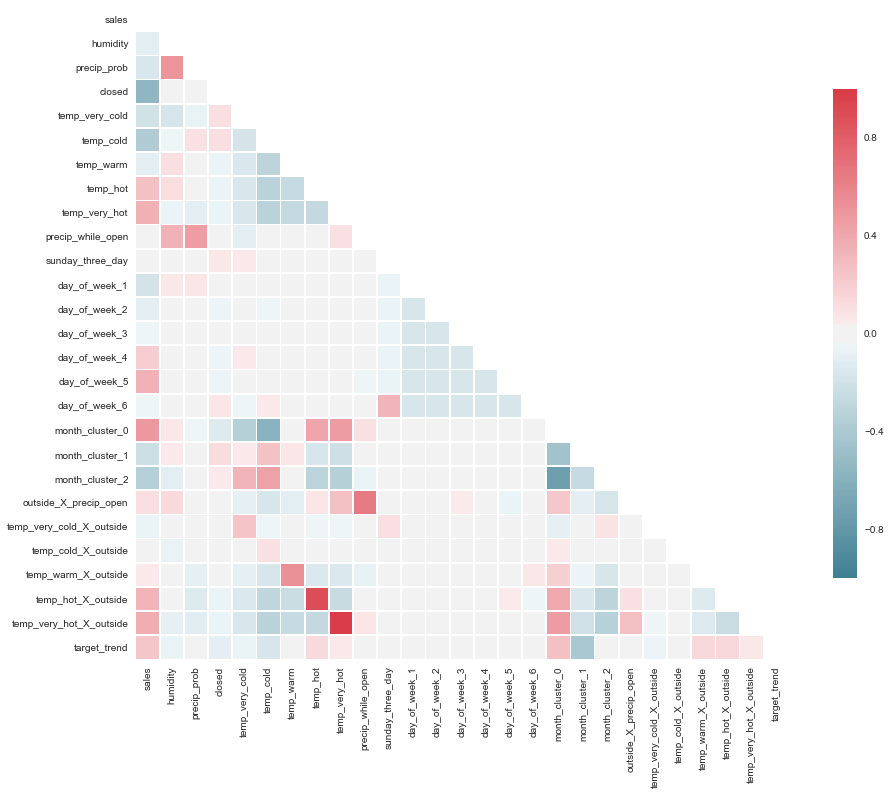

In [11514]:
def corr_chart(df):
    
    corr = df.corr()

    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    sns.set_style('whitegrid')
    f, ax = plt.subplots(figsize=(16, 12))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
                square=True, linewidths=.75, annot=False, cbar_kws={"shrink": .75});
    
corr_chart(dfx)

## Update Sales

In [11371]:
# # File from Start based on Target Variable
# current_sales_df = import_parse(rest_1_file)

In [11372]:
# date = '2019-06-13'
# sales = 15209.75
# covers = 207
# outside = 1
# closed = 0

# def add_sales_row(date, sales):
    
#     df = pd.DataFrame({'sales': sales,
#                        'covers': covers,
#                       'outside': outside,
#                       'closed': closed},
#                        index=[date])
    
#     return df

# temp = add_sales_row(date, sales)

In [11373]:
# def build_sales_df(df, temp):
    
#     df = df.append(temp)
    
#     return df
    
# current_sales_df = build_sales_df(current_sales_df, temp)

In [11374]:
# # Download Current DataFrame to CSV
# current_sales_df.to_csv(f'rest_1_clean_updated_{start_date}_to_{end_date}.csv')

In [11375]:
# df_import = pd.read_csv('rest_1_clean_updated_2017-01-01_to_2019-06-17.csv', parse_dates=True, index_col='Unnamed: 0')

# def import_current(df):
    
#     df.index = pd.to_datetime(df.index)
    
#     df = add_ppa(df)
    
#     target_list = ['sales', 'covers', 'ppa']

#     target_to_drop = [t for t in target_list if t != target]

#     df = df.drop(target_to_drop, axis=1)
    
#     return df

# current_df = import_current(df_import)

### Add Recent Sales Data

In [11376]:
# # Import Most Recent DataFrame
# df_before_features = pd.read_csv('csv_before_features.csv', index_col='date', parse_dates=True)

# # Create New Weather DataFrame with Updated Data
# new_date_start = '2019-06-15'
# new_date_end = '2019-06-17'

# def update_current_df(sales_df, df_before_features, new_date_start, new_end_date):
    
#     sales_df = sales_df[new_date_start:]
    
#     sales_df = sales_df.rename_axis(index = 'date')
#     sales_df.index = pd.to_datetime(sales_df.index)

#     ## Find Lat Long for Business
#     lat, long = yelp_lat_long(search_business, location)

#     ## Pull Weather Data / Forecast
#     weather_df = build_weather_df(weather_call(new_date_start, new_date_end, lat, long))
    
#     ## Parse, Clean, Engineer
#     df = pd.merge(sales_df, weather_df, how='left', on='date')
#     df, _ = one_hot_temp(df, temp_enc)
#     df = pd.concat([df_before_features, df])
#     df = target_trend_engineering(feature_engineering(df))
    
#     return df
    
# current_df = update_current_df(current_df, df_before_features, new_date_start, new_date_end)

## Test / Train / Split

### Drop Closed Days?

In [11377]:
drop_all_closed = False

if drop_all_closed:
    
    current_df = current_df[current_df['closed'] == 0]

In [11378]:
dfx.columns

Index(['sales', 'humidity', 'precip_prob', 'closed', 'temp_very_cold',
       'temp_cold', 'temp_warm', 'temp_hot', 'temp_very_hot',
       'precip_while_open', 'sunday_three_day', 'day_of_week_1',
       'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5',
       'day_of_week_6', 'month_cluster_0', 'month_cluster_1',
       'month_cluster_2', 'outside_X_precip_open', 'temp_very_cold_X_outside',
       'temp_cold_X_outside', 'temp_warm_X_outside', 'temp_hot_X_outside',
       'temp_very_hot_X_outside', 'target_trend'],
      dtype='object')

In [11379]:
def drop_weather(df):
    
    no_weather = False

    if no_weather:

        df = df.drop(['humidity', 'precip_prob', 'temp_very_cold', 'temp_cold', 'temp_hot', 'temp_very_hot', 'precip_while_open', \
                     'temp_very_cold_X_outside', 'temp_cold_X_outside', 'temp_hot_X_outside','temp_very_hot_X_outside', 'outside_X_precip_open'], axis=1)
        
        df = df.merge(df_outside, on='date', how='left')
        
        return df
    
    else:
        
        return df
    
dfx = drop_weather(dfx)
dfx.head()
    

,sales,humidity,precip_prob,closed,temp_very_cold,temp_cold,temp_warm,temp_hot,temp_very_hot,precip_while_open,...,month_cluster_0,month_cluster_1,month_cluster_2,outside_X_precip_open,temp_very_cold_X_outside,temp_cold_X_outside,temp_warm_X_outside,temp_hot_X_outside,temp_very_hot_X_outside,target_trend
date,,,,,,,,,,,,,,,,,,,,,
2017-01-02,12814.84,0.92,0.79,0,0.0,1.0,0.0,0.0,0.0,0,...,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2017-01-03,12442.11,0.94,0.77,0,0.0,1.0,0.0,0.0,0.0,1,...,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2017-01-04,11877.64,0.40,0.00,0,0.0,1.0,0.0,0.0,0.0,0,...,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2017-01-05,14057.79,0.48,0.00,0,1.0,0.0,0.0,0.0,0.0,0,...,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2017-01-06,14531.97,0.48,0.00,0,1.0,0.0,0.0,0.0,0.0,0,...,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [11527]:
def cv_split(df):
    
    features = dfx.drop([target], axis=1)[days_fwd:]
    y = dfx[target][days_fwd:]
    
    return features, y

cv_features, cv_y = cv_split(dfx)
baseline_cv_x, baseline_cv_y = cv_split(mod_baseline)

In [11548]:
def train_test_split(df):
    
    # Separate Target & Features
    y = df[target]
    features = df.drop([target], axis=1)
    
    # Test / Train / Split
    train_date_start = '2017-01-01'
    train_date_end = '2018-12-31'
    
    X_train = features[pd.to_datetime(train_date_start) + pd.DateOffset(days_fwd):train_date_end]
    X_test = features[pd.to_datetime(train_date_end) + pd.DateOffset(1): ]
    
    y_train = y[pd.to_datetime(train_date_start) + pd.DateOffset(days_fwd):train_date_end]
    y_test = y[pd.to_datetime(train_date_end) + pd.DateOffset(1): ]
    
    # Scale
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test = pd.DataFrame(X_test_scaled, columns=X_train.columns)
    
    print('Train set: ', len(X_train))
    print('Test set: ', len(X_test))
    
    return X_train, X_test, y_train, y_test, scaler
    
X_train, X_test, y_train, y_test, scaler = train_test_split(dfx)
baseline_X_train, baseline_X_test, baseline_y_train, baseline_y_test, baseline_scaler = train_test_split(mod_baseline)

Train set:  691
Test set:  169
Train set:  691
Test set:  169


### Linear Regression

In [11549]:
def linear_regression_model(X_train, y_train):
    
    lr = LinearRegression(fit_intercept=True)
    lr_rgr = lr.fit(X_train, y_train)
    
    return lr_rgr

In [11550]:
lr_rgr = linear_regression_model(X_train, y_train)
baseline_lr_rgr = linear_regression_model(baseline_X_train, baseline_y_train)

In [11551]:
def rgr_score(rgr, X_train, y_train, X_test, y_test, cv_features, cv_y):
    
    y_hat = rgr.predict(X_test)
    sum_squares_residual = sum((y_test - y_hat)**2)
    sum_squares_total = sum((y_test - np.mean(y_test))**2)
    r_squared = 1 - (float(sum_squares_residual))/sum_squares_total
    adjusted_r_squared = 1 - (1-r_squared)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
    print('Formula Scores - R-Squared: ', r_squared, 'Adjusted R-Squared: ', adjusted_r_squared, '\n')
    
    train_score = rgr.score(X_train, y_train)
    test_score = rgr.score(X_test, y_test)
    
    y_pred = rgr.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    pred_df = pd.DataFrame(y_pred, index=y_test.index)
    pred_df = pred_df.rename(columns={0: target})
    
    print('Train R-Squared:  ', train_score)
    print('Test R-Squared:  ', test_score, '\n')
    
    print('Root Mean Squared Error: ', rmse, '\n')
    
    print('Cross Val Avg R-Squared: ',  \
          np.mean(cross_val_score(rgr, cv_features, cv_y, cv=10, scoring='r2')), '\n')
    
    print('Intercept:  ', rgr.intercept_, '\n')
    print('Coefficients:  \n')
    
    for index, col_name in enumerate(X_test.columns):
        print(col_name, ' --> ', rgr.coef_[index])
        
    return pred_df

In [11552]:
pred_df = rgr_score(lr_rgr, X_train, y_train, X_test, y_test, cv_features, cv_y)

baseline_preds = rgr_score(baseline_lr_rgr, baseline_X_train, baseline_y_train, baseline_X_test, baseline_y_test, baseline_cv_x, baseline_cv_y)

Formula Scores - R-Squared:  0.8314590736057758 Adjusted R-Squared:  0.8005994673645798 

Train R-Squared:   0.781664938228909
Test R-Squared:   0.8314590736057759 

Root Mean Squared Error:  1294.243986043061 

Cross Val Avg R-Squared:  0.6784487693497173 

Intercept:   13151.944683753753 

Coefficients:  

humidity  -->  -1430.5968014821779
precip_prob  -->  -285.63684206335836
closed  -->  -13810.080481616358
temp_very_cold  -->  -257.0253619843726
temp_cold  -->  -34.53827320300603
temp_warm  -->  520.331150761081
temp_hot  -->  516.9458825323867
temp_very_hot  -->  -745.7133981060797
precip_while_open  -->  329.17268853749164
sunday_three_day  -->  1459.4669674345812
day_of_week_1  -->  -131.00317778178092
day_of_week_2  -->  263.2031013715046
day_of_week_3  -->  896.9247158051236
day_of_week_4  -->  2701.813099501862
day_of_week_5  -->  3747.196055875591
day_of_week_6  -->  1130.87365120462
month_cluster_0  -->  30.30786650568939
month_cluster_1  -->  261.03403614494533
month_clu

### Prediction Function

In [11553]:
outside = 1

def predict_df(clf, scaler, X_train, current_df, date_1, date_2):
    
    # Find Lat Long for Business
    lat, long = yelp_lat_long(search_business, location)
    
    # Pull Weather Data / Forecast
    weather_df = build_weather_df(weather_call(date_1, date_2, lat, long))
    
    day_of_week, apparent_temperature = weather_df['day_of_week'], weather_df['apparent_temperature']
    weather_df['outside'] = outside
    
    # One Hot Encode Temperature Using Fitted Encoder
    df, _ = one_hot_temp(weather_df, temp_enc)
    
    df['closed'] = 0
    
    # Add Feature Engineering
    df = feature_engineering(df)
    
    # Add Sales Data for Sales Trend Engineering
    current_df = current_df[target]
    df = pd.merge(df, current_df, on='date', how='left')
    df[target] = df[target].fillna(method='ffill')
    
    df = target_trend_engineering(df)
    df = df.drop([target], axis=1)
    
    # Ensure Column Parity
    missing_cols = set(X_train.columns) - set(df.columns)
    
    for c in missing_cols:
        df[c] = 0
        
    df = df[X_train.columns][-2:]
    
    # Scale Transform
    df_scaled = scaler.transform(df)
    df = pd.DataFrame(df_scaled, columns=df.columns, index=df.index)
    
    # Predict and Build Prediction DataFrame for Review
    pred_array = pd.DataFrame(clf.predict(df), index=df.index, columns=[target])
    pred_df = df[df.columns[(df != 0).any()]]
    pred_df = pd.concat([pred_df, day_of_week, apparent_temperature], axis=1)
    
    final_predict = pd.concat([pred_array, pred_df], axis=1)
    
    return final_predict

In [11554]:
tonight = predict_df(lr_rgr, scaler, X_train, dfx, pd.datetime.now().date() + pd.DateOffset(-days_fwd), pd.datetime.now().date())
tonight[-2:]

Weather Location: Jupiter Disco


,sales,humidity,precip_prob,temp_hot,temp_very_hot,precip_while_open,day_of_week_2,day_of_week_3,month_cluster_0,outside_X_precip_open,temp_hot_X_outside,temp_very_hot_X_outside,target_trend,day_of_week,apparent_temperature
date,,,,,,,,,,,,,,,
2019-06-19,15950.336915,0.922078,0.00,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.428224,2,68.57
2019-06-20,17751.699538,0.779221,0.19,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.390968,3,76.58


## Lasso

In [11536]:
def lasso_model(X_train, y_train):

    lassoReg = Lasso(fit_intercept=True, alpha=.05)
    lasso_rgr = lassoReg.fit(X_train,y_train)

    return lasso_rgr

lasso_rgr = lasso_model(X_train, y_train)

baseline_lasso = lasso_model(baseline_X_train, baseline_y_train)

In [11537]:
pred_df_ppa_lasso = rgr_score(lasso_rgr, X_train, y_train, X_test, y_test, cv_features, cv_y)

baseline_lasso = rgr_score(baseline_lasso, baseline_X_train, baseline_y_train, baseline_X_test, baseline_y_test, baseline_cv_x, baseline_cv_y)

Formula Scores - R-Squared:  0.8314323274764113 Adjusted R-Squared:  0.8005678240565992 

Train R-Squared:   0.7816645985160647
Test R-Squared:   0.8314323274764113 

Root Mean Squared Error:  1294.3466751779988 

Cross Val Avg R-Squared:  0.678457985108043 

Intercept:   13148.727273355167 

Coefficients:  

humidity  -->  -1430.1528362812999
precip_prob  -->  -283.34453313562307
closed  -->  -13805.88566023607
temp_very_cold  -->  -221.80990823827818
temp_cold  -->  0.42931203698637216
temp_warm  -->  555.9345371314138
temp_hot  -->  552.6446950518861
temp_very_hot  -->  -695.2977967077175
precip_while_open  -->  325.0905311124925
sunday_three_day  -->  1455.5221565455486
day_of_week_1  -->  -131.766259785456
day_of_week_2  -->  261.5629839884926
day_of_week_3  -->  895.483365148691
day_of_week_4  -->  2700.2704367121014
day_of_week_5  -->  3745.7127220957136
day_of_week_6  -->  1130.0307377729198
month_cluster_0  -->  0.0
month_cluster_1  -->  230.44835585239383
month_cluster_2  -->

In [11388]:
tonight = predict_df(lasso_rgr, scaler, X_train, dfx, pd.datetime.now().date() + pd.DateOffset(-days_fwd), pd.datetime.now().date())
tonight[-2:]

Weather Location: Jupiter Disco


,sales,humidity,precip_prob,temp_hot,precip_while_open,day_of_week_1,day_of_week_2,month_cluster_0,outside_X_precip_open,temp_hot_X_outside,target_trend,day_of_week,apparent_temperature
date,,,,,,,,,,,,,
2019-06-18,15468.441241,0.935065,0.84,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.504817,1,70.36
2019-06-19,16755.474839,0.883117,0.26,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.428224,2,70.71


<Figure size 864x576 with 0 Axes>

ResidualsPlot(alpha=0.75,
       ax=<matplotlib.axes._subplots.AxesSubplot object at 0x1c3b0af0b8>,
       hist=False, line_color=None, model=None, test_color=None,
       train_color=None)

0.8314323274764113

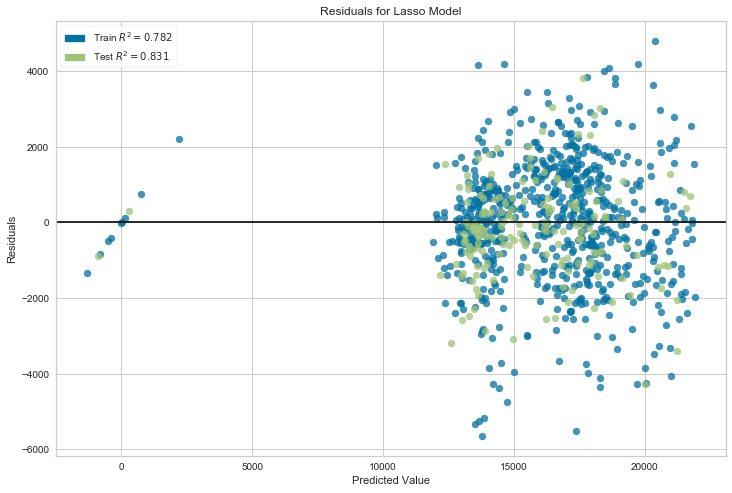

In [11389]:
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.features.importances import FeatureImportances

plt.figure(figsize=(12,8))

visualizer = ResidualsPlot(lasso_rgr, hist=False)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

FeatureImportances(absolute=False,
          ax=<matplotlib.axes._subplots.AxesSubplot object at 0x1c3cf98208>,
          labels=['Humidity', 'Precip_Prob', 'Closed', 'Temp_Very_Cold', 'Temp_Cold', 'Temp_Hot', 'Temp_Very_Hot', 'Precip_While_Open', 'Sunday_Three_Day', 'Day_Of_Week_1', 'Day_Of_Week_2', 'Day_Of_Week_3', 'Day_Of_Week_4', 'Day_Of_Week_5', 'Day_Of_Week_6', 'Month_Cluster_0', 'Month_Cluster_1', 'Month_Cluster_2', 'Outside_X_Precip_Open', 'Temp_Very_Cold_X_Outside', 'Temp_Cold_X_Outside', 'Temp_Hot_X_Outside', 'Temp_Very_Hot_X_Outside', 'Target_Trend'],
          model=None, relative=False, stack=False, xlabel=None)

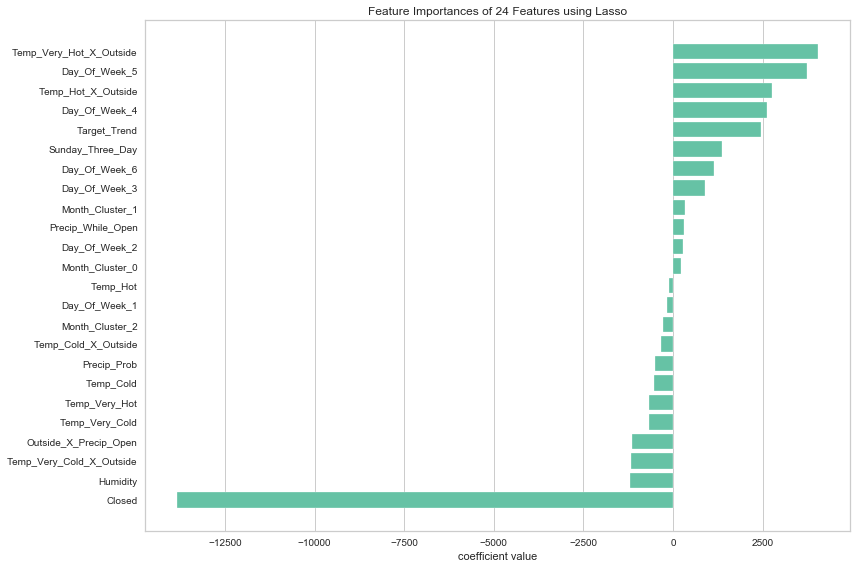

In [11210]:
features = list(X_train.columns)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot()

labels = list(map(lambda x: x.title(), features))
visualizer = FeatureImportances(lasso_rgr, ax=ax, labels=labels, relative=False)

visualizer.fit(X_train, y_train)
visualizer.poof()

### Random Forest Regression

In [11533]:
def rf_regression_model(X_train, y_train):
    
    rfr = RandomForestRegressor(max_depth= 11, 
                                max_features= 0.60, 
                                min_impurity_decrease= 0.005, 
                                n_estimators= 300,
                                min_samples_leaf = 2,
                                min_samples_split = 2,
                                random_state = 0)
    
    rfr_rgr = rfr.fit(X_train, y_train)
    
    return rfr_rgr

In [11534]:
rfr_rgr = rf_regression_model(X_train, y_train)

In [11535]:
def rfr_score(rgr, X_test, y_test, cv_features, cv_y):
    
    y_hat = rgr.predict(X_test)
    sum_squares_residual = sum((y_test - y_hat)**2)
    sum_squares_total = sum((y_test - np.mean(y_test))**2)
    r_squared = 1 - (float(sum_squares_residual))/sum_squares_total
    adjusted_r_squared = 1 - (1-r_squared)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
    print('Formula Scores - R-Squared: ', r_squared, 'Adjusted R-Squared: ', adjusted_r_squared, '\n')
    
    train_score = rgr.score(X_train, y_train)
    test_score = rgr.score(X_test, y_test)
    
    y_pred = rgr.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    pred_df = pd.DataFrame(y_pred, index=y_test.index)
    pred_df = pred_df.rename(columns={0: target})
    
    print('Train R-Squared:  ', train_score)
    print('Test R-Squared:  ', test_score, '\n')
    
    print('Root Mean Squared Error: ', rmse, '\n')
    
    print('Cross Val Avg R-Squared: ',  \
          np.mean(cross_val_score(rgr, cv_features, cv_y, cv=10, scoring='r2')), '\n')
        
    return pred_df

pred_df = rfr_score(rfr_rgr, X_test, y_test, cv_features, cv_y) 

Formula Scores - R-Squared:  0.8196000605472993 Adjusted R-Squared:  0.7865690857179315 

Train R-Squared:   0.8914251745921165
Test R-Squared:   0.8196000605472994 

Root Mean Squared Error:  1339.0033420819104 

Cross Val Avg R-Squared:  0.6470395821127155 



# Random Forest Regression Prediction

In [11214]:
tonight = predict_df(rfr_rgr, scaler, X_train, dfx, pd.datetime.now().date() + pd.DateOffset(-days_fwd), pd.datetime.now().date())
tonight[-2:]

Weather Location: Jupiter Disco


,sales,humidity,temp_very_hot,precip_while_open,day_of_week_1,month_cluster_0,outside_X_precip_open,temp_very_hot_X_outside,target_trend,day_of_week,apparent_temperature
date,,,,,,,,,,,
2019-06-17,17066.270504,0.698630,1.0,0.0,0.0,1.0,0.0,1.0,0.564911,0,72.89
2019-06-18,16601.352380,0.945205,1.0,1.0,1.0,1.0,1.0,1.0,0.524329,1,70.46


### Grid Search Helper Function

In [11215]:
def run_grid_search(rgr, params, X_train, y_train):
    
    cv = 5
    n_jobs = -1
    scoring = 'neg_mean_squared_error'
    
    grid = GridSearchCV(rgr, params, cv=cv, n_jobs=n_jobs, scoring=scoring, verbose=10)
    grid = grid.fit(X_train, y_train)
    
    best_grid_rgr = grid.best_estimator_
    
    print('Grid Search: ', rgr.__class__.__name__, '\n')
    print('Grid Search Best Score: ', grid.best_score_)
    print('Grid Search Best Params: ', grid.best_params_)
    print('Grid Search Best Estimator: ', grid.best_estimator_)

    return best_grid_rgr


In [11216]:
params = {
          'n_estimators': [250, 275, 300, 350, 400,500],
          'max_depth': [5, 7, 9, 11, 13, 15],
          'min_impurity_decrease': [0.005, 0.001, 0.0001],
          'max_features': ['auto', 0.65, 0.75, 0.85, 0.95]
        }

best_grid_rgr = run_grid_search(rfr_rgr, params, X_train, y_train)

Fitting 5 folds for each of 540 candidates, totalling 2700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   47.5s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   

Grid Search:  RandomForestRegressor 

Grid Search Best Score:  -3244769.4627099456
Grid Search Best Params:  {'max_depth': 7, 'max_features': 0.65, 'min_impurity_decrease': 0.005, 'n_estimators': 350}
Grid Search Best Estimator:  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features=0.65, max_leaf_nodes=None,
           min_impurity_decrease=0.005, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=350, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)


### OLS Model

In [11217]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [11400]:
f = ''

for c in dfx.columns:
    
    f += c + '+'
    
x = f[6:-1]

In [11401]:
f= target + '~' + x

model = ols(formula=f, data=dfx).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     132.8
Date:                Thu, 20 Jun 2019   Prob (F-statistic):          8.19e-266
Time:                        09:22:13   Log-Likelihood:                -7542.0
No. Observations:                 861   AIC:                         1.513e+04
Df Residuals:                     836   BIC:                         1.525e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                 1380.5170   1521.861      0.907      0.365   -1606.600    4367.634
humidity                 -1678.0156    354.381     -4.735      0.000   -2373.596    -982.435
precip_prob               -214.8610    331.042     -0.649      0.516    -864.632     434.910
closed                   -1.387e+04    487.988    -28.426      0.000   -1.48e+04   -1.29e+04
temp_very_cold             233.5006    396.212      0.589      0.556    -544.186    1011.187
temp_cold                  259.9028    364.430      0.713      0.476    -455.403     975.209
temp_warm                  725.4881    368.296      1.970      0.049       2.594    1448.382
temp_hot                   716.1835    422.720      1.694      0.091    -113.533    1545.900
temp_very_hot             -554.5580    651.594     -0.851      0.395   -1833.511     724.395
precip_while_open          378.7416    259.732      1.458      0.145    -131.061     888.544
sunday_three_day          1750.2716    436.490      4.010      0.000     893.526    2607.017
day_of_week_1             -107.7544    200.237     -0.538      0.591    -500.782     285.273
day_of_week_2              189.2217    201.474      0.939      0.348    -206.232     584.676
day_of_week_3              869.8803    200.806      4.332      0.000     475.736    1264.024
day_of_week_4             2684.0497    201.821     13.299      0.000    2287.914    3080.186
day_of_week_5             3848.9943    201.571     19.095      0.000    3453.351    4244.638
day_of_week_6             1027.8927    207.968      4.943      0.000     619.692    1436.093
month_cluster_0            488.9571    546.754      0.894      0.371    -584.214    1562.128
month_cluster_1            682.6228    481.438      1.418      0.157    -262.346    1627.592
month_cluster_2            208.9370    537.222      0.389      0.697    -845.526    1263.400
outside_X_precip_open    -1154.3080    331.321     -3.484      0.001   -1804.626    -503.990
temp_very_cold_X_outside  -853.3947    733.203     -1.164      0.245   -2292.529     585.740
temp_cold_X_outside         59.9865    935.210      0.064      0.949   -1775.650    1895.623
temp_warm_X_outside       1350.4045    281.748      4.793      0.000     797.388    1903.422
temp_hot_X_outside        3230.6052    336.316      9.606      0.000    2570.483    3890.727
temp_very_hot_X_outside   4776.5295    731.293      6.532      0.000    3341.144    6211.915
target_trend              1.242e+04   2326.865      5.338      0.000    7853.732     1.7e+04
==============================================================================
Omnibus:                       26.559   Durbin-Watson:                   1.801
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.112
Skew:                           0.301   Prob(JB):       

## XGB Regressor

In [11220]:
from xgboost import XGBRegressor

In [11396]:
def xgb_model(X_train, y_train):
    
    objective = 'reg:linear'
    booster = 'gbtree'
    nthread = 4
    learning_rate = 0.02
    max_depth = 3
    colsample_bytree = 0.75
    n_estimators = 450
    min_child_weight = 2
    
    xgb_rgr= XGBRegressor(booster=booster, objective=objective, colsample_bytree=colsample_bytree, learning_rate=learning_rate, \
                                max_depth=max_depth, nthread=nthread, n_estimators=n_estimators, min_child_weight=min_child_weight, random_state = 0)
    
    xgb_rgr = xgb_rgr.fit(X_train, y_train)
    
    return xgb_rgr

In [11397]:
xgb_rgr = xgb_model(X_train, y_train)

In [11398]:
# Convert column names back to original
X_test = X_test[X_train.columns]

In [11399]:
pred_df_covers_xgb = rfr_score(xgb_rgr, X_test, y_test, cv_features, cv_y) 

Formula Scores - R-Squared:  0.835448257897047 Adjusted R-Squared:  0.8053190656810134 

Train R-Squared:   0.8272349873106326
Test R-Squared:   0.8354482578970471 

Root Mean Squared Error:  1278.8355762750668 

Cross Val Avg R-Squared:  0.6668620522192908 



## HYBRID

In [11225]:
filex = 'predicted_ppa_timeseries.csv'
df_ts = pd.read_csv(filex,index_col='date',parse_dates=True)

In [11226]:
pred_df = pred_df_covers_xgb.merge(df_ts, on='date', how='left')
pred_df.head()

,sales,pred_ppa
date,,
2019-01-01,-24.125895,6.281795
2019-01-02,13548.809570,80.328907
2019-01-03,14045.452148,85.517093
2019-01-04,15993.259766,83.712033
2019-01-05,17166.007812,81.003838


In [11035]:
pred_df['sales'] = pred_df['covers'] * pred_df['pred_ppa']

In [11036]:
pred_df = pred_df[['sales']]

In [11071]:
r2 = metrics.r2_score(y_test, pred_df)

In [11072]:
r2

0.7827614707369226

In [11077]:
rmse = np.sqrt(mean_squared_error(y_test, pred_df))
rmse

1474.664822041796

In [ ]:
tonight = predict_df(xgb_rgr, scaler, X_train, dfx, pd.datetime.now().date() + pd.DateOffset(-days_fwd), pd.datetime.now().date())
tonight[-2:]

In [9940]:
xgb1 = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.015, 0.02, .025], #so called `eta` value
              'max_depth': [3, 4, 5],
              'min_child_weight': [1, 2, 3],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.55, 0.60, 0.65],
              'n_estimators': [400, 500, 600]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 3,
                        n_jobs = 5,
                        verbose=True,
                        scoring = 'neg_mean_squared_error')

xgb_grid.fit(X_train,
        y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   33.9s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  3.3min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  8.6min
[Parallel(n_jobs=5)]: Done 729 out of 729 | elapsed: 12.9min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
       fit_params=None, iid='warn', n_jobs=5,
       param_grid={'nthread': [4], 'objective': ['reg:linear'], 'learning_rate': [0.01, 0.02, 0.03], 'max_depth': [3, 4, 5], 'min_child_weight': [1, 2, 3], 'silent': [1], 'subsample': [0.7], 'colsample_bytree': [0.55, 0.6, 0.65], 'n_estimators': [400, 500, 600]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=True)

-706.914114382183
{'colsample_bytree': 0.65, 'learning_rate': 0.02, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


## CLEAN RUN